In [112]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn import linear_model
from datetime import datetime, timedelta
from scipy.stats import multivariate_normal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [113]:
pd.options.mode.chained_assignment = None

## *Задание 1*
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [114]:
data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
data.total_cases.replace(np.NaN, 1, inplace=True)
df = data.copy()
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [115]:
def creat_train_and_test_data_in_context_country(df, country):
    start_date = datetime(2020, 3, 3)
    size_train_date = 50
    last_date = datetime(2020, 9, 1)
    df_copy = df.copy()
    df_copy = df_copy[df_copy['location'] == country]

    df_copy['date'] = df_copy['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d") )
    train_data = df_copy[(df_copy['date'] >= start_date) & (df_copy['date'] < start_date + timedelta(days=size_train_date))]
    test_data = df_copy[(df_copy['date'] <= last_date) & (df_copy['date'] >= start_date + timedelta(days=size_train_date))]
    train_data['date'] = train_data['date'].apply(lambda x: (x - datetime(2020,3,2)).days)
    train_data['free_value'] = np.ones(len(train_data))
    test_data['date'] = test_data['date'].apply(lambda x: (x - datetime(2020,3,2)).days)
    test_data['free_value'] = np.ones(len(test_data))
    return train_data[['total_cases', 'date', 'free_value']], test_data[['total_cases', 'date', 'free_value']]

In [116]:
train_data, test_data = creat_train_and_test_data_in_context_country(df, "Russia")

In [117]:
x_train, y_train = train_data[['free_value','date']], train_data['total_cases']
x_test, y_test = test_data[['free_value','date']], test_data['total_cases']

## *Задание 2*
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем


In [118]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train['date'], y=y_train, name = 'train'))
fig.add_trace(go.Scatter(x=x_test['date'], y=y_test, name = 'test'))
fig.show()

### a. Линейная регрессия с экспоненциальным ростом
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [119]:

model_exp_reg = linear_model.LinearRegression(fit_intercept=False)
model_exp_reg.fit(x_train, np.log(y_train))
model_exp_reg.coef_

array([1.62244624, 0.19829091])

In [120]:
x_predict = pd.concat([x_train, x_test[:10]])

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train['date'], y=y_train, name = 'train'))
fig.add_trace(go.Scatter(x=x_test['date'], y=y_test, name = 'test'))
fig.add_trace(go.Scatter(x=x_predict['date'], y= np.exp(model_exp_reg.predict(x_predict)), name = 'predict'))
fig.show()

### b. Апостериорное распределение
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [122]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[20, 0], [0,20]])

In [123]:
N = 250
X = np.linspace(1.2, 2.2, N)
Y = np.linspace(0.18, 0.22, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [124]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x = np.array(x)
    y = np.array(y)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise)) * np.matmul(np.transpose(x), x) )
    a =  np.matmul(np.linalg.inv(cur_sigma), cur_mu)
    b = (1 / (sigma_noise)) * np.matmul( x.T, y)

    mu_n =  np.matmul(sigma_n, a + b)
    return mu_n, sigma_n

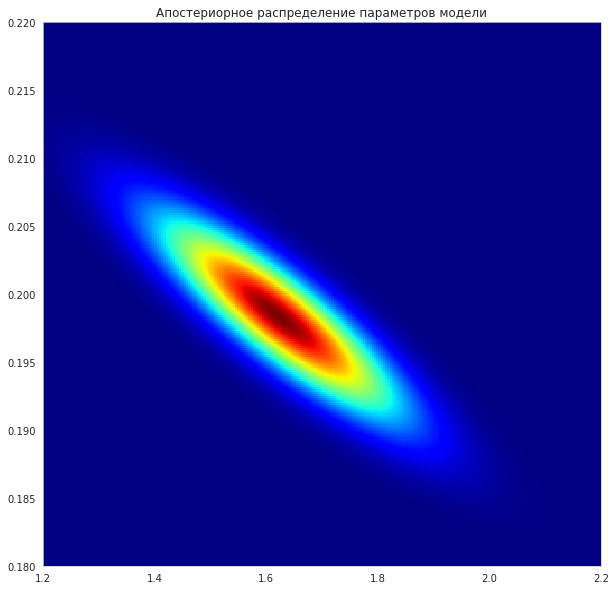

In [125]:
mu_n, sigma_n = bayesian_update(cur_mu, cur_sigma, np.array(x_train), np.array(np.log(y_train)))

Z = multivariate_normal.pdf(pos, mean=mu_n, cov=sigma_n)

plt.figure(figsize=(10, 10))
plt.xlim((1.2, 2.2))
plt.ylim((0.18, 0.22))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title("Апостериорное распределение параметров модели")

plt.show();

### c. Просэмплирование и прогноз
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [126]:
def myplot_sample_lines(x_train, y_train, mu, sigma, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(x_train['date'], np.exp(w[0] + w[1]*x_train['date']), 'k-', lw=.02)
    plt.plot(x_train['date'], y_train, '-', lw=1)
    

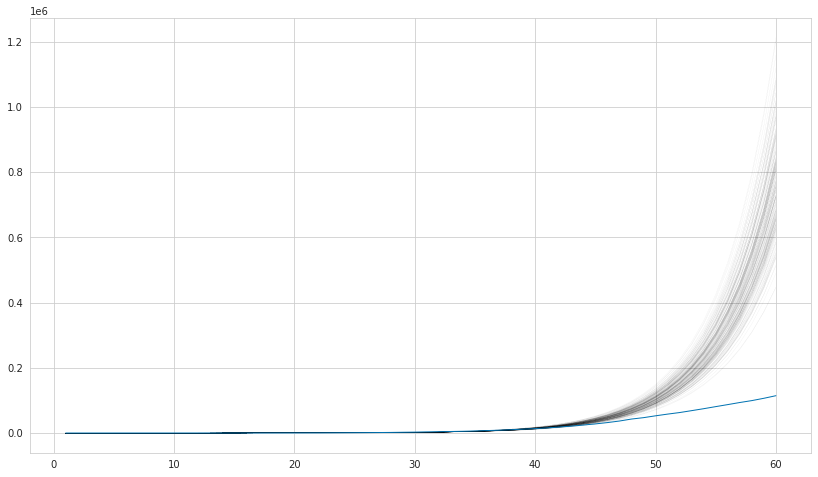

In [127]:
fig = plt.figure(figsize=(14, 8))
myplot_sample_lines(pd.concat([x_train, x_test[:10]]) , pd.concat([y_train, y_test[:10]]), mu_n, sigma_n, 200)

In [128]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n , xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

In [129]:
x_all_period = pd.concat([x_train, x_test]) 

In [130]:
N = len(x_all_period)
xs = np.linspace(0, len(x_all_period), N)

In [131]:
def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1] + 100))
    # ax.set_ylim((-2, 2))

    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red")

    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="дисперсия предсказаний")

    ax.legend(fontsize=legend_fontsize)

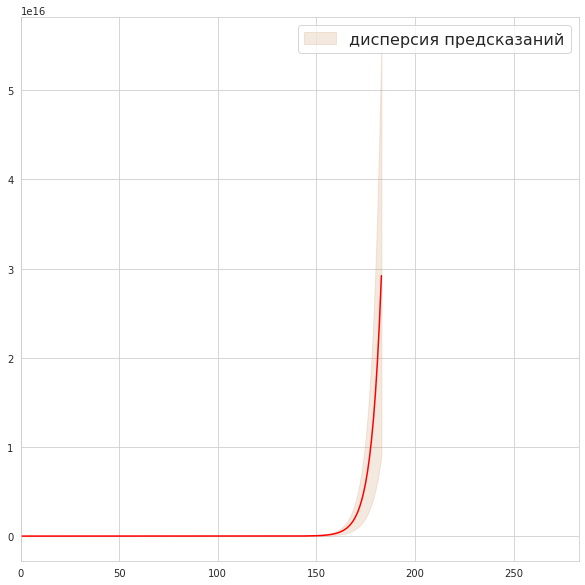

In [132]:
x = sample_statistics(mu_n, sigma_n, xs, n=100)
plot_predictions(xs, mu_n, x)

In [133]:
date_start = pd.to_datetime("2020-03-03")
date_may = pd.to_datetime("2020-05-01")
date_june = pd.to_datetime("2020-06-01")
date_sept = pd.to_datetime("2020-09-01")

X_may = np.array([[(date_may - date_start).days]])
X_june = np.array([[(date_june - date_start).days]])
X_sept = np.array([[(date_sept - date_start).days]])

y_may_total = int(np.exp(mu_n[0] + mu_n[1] * X_may))
y_june_total = int(np.exp(mu_n[0] + mu_n[1] * X_june))
y_sept_total = int(np.exp(mu_n[0] + mu_n[1] * X_sept))

print(f"К 1 мая: {y_may_total} случаев")
print(f"К 1 июня: {y_june_total} случаев")
print(f"К 1 сентября: {y_sept_total} случаев")

К 1 мая: 610622 случаев
К 1 июня: 285576041 случаев
К 1 сентября: 23957441424024392 случаев


## Задание 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана. Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t

### а. Линейная регрессия с сигмоидальной функцией
  Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии

In [134]:
x_train['date^2'] = x_train['date'] ** 2 
x_train.head()

,free_value,date,date^2
123955,1.0,1,1
123956,1.0,2,4
123957,1.0,3,9
123958,1.0,4,16
123959,1.0,5,25


In [135]:
x_test['date^2'] = x_test['date'] ** 2 

In [136]:
model_exp_reg = linear_model.LinearRegression(fit_intercept=False)
model_exp_reg.fit(x_train, np.log(y_train))
model_exp_reg.coef_

array([ 0.86323587,  0.28589211, -0.00171767])

In [137]:
x_predict = pd.concat([x_train, x_test])

In [138]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train['date'], y=y_train, name = 'train'))
fig.add_trace(go.Scatter(x=x_test['date'], y=y_test, name = 'test'))
fig.add_trace(go.Scatter(x=x_predict['date'], y= np.exp(model_exp_reg.predict(x_predict)).cumsum(), name = 'predict'))
fig.show()

### b. Апостериорное распределение 
  Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [139]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[20, 0, 0], [0, 20, 0], [0, 0, 20]])

In [140]:
mu_n, sigma_n = bayesian_update(cur_mu, cur_sigma, np.array(x_train), np.array(np.log(y_train)))

In [141]:
print(f"""Параметры распределения: 
Мат.ожидание: {mu_n},
Дисперсия: {sigma_n}
""")

Параметры распределения: 
Мат.ожидание: [ 0.86221159  0.28597256 -0.00171899],
Дисперсия: [[ 4.87411819e-02 -3.86004801e-03  6.36970875e-05]
 [-3.86004801e-03  3.98927011e-04 -7.35248489e-06]
 [ 6.36970875e-05 -7.35248489e-06  1.44185574e-07]]



### c. Просэмплирование и прогноз
  Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [142]:
def myplot_sample_lines_sigma(x_train, y_train, mu, sigma, n=20):
    fig = plt.figure(figsize=(10, 10))
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(x_train['date'], np.exp(w[0] + w[1]*x_train['date'] + w[2]*x_train['date^2']).cumsum(), 'k-', lw=.4)
    plt.plot(x_train['date'], y_train, '-', lw=1)

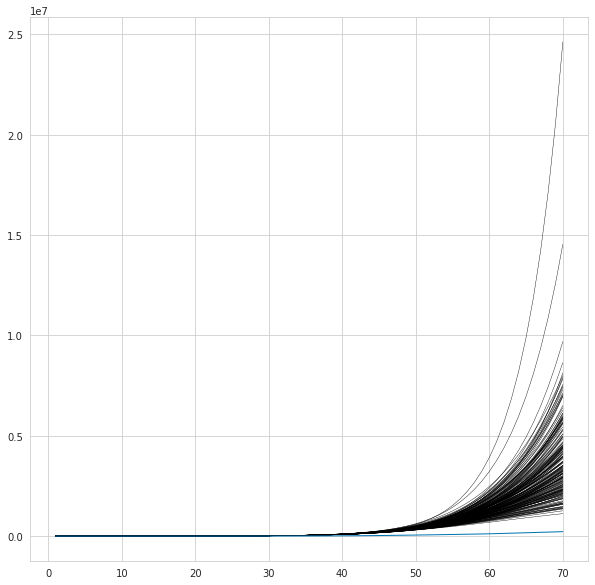

In [143]:
myplot_sample_lines_sigma(pd.concat([x_train, x_test[:20]]) , pd.concat([y_train, y_test[:20]]), mu_n, sigma_n, 200)

In [144]:
x_all_period = pd.concat([x_train, x_test[:30]]) 

In [148]:
def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1] + 100))
    # ax.set_ylim((-2, 2))

    ax.plot(xs, np.exp(mu[2] * xs**2 + mu[1]*xs + mu[0]).cumsum(), color="red")

    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="дисперсия предсказаний")

    ax.legend(fontsize=legend_fontsize)

In [146]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs + w[2]*xs**2).cumsum()
    return res

In [147]:
N = len(x_all_period)
xs = np.linspace(0, len(x_all_period), N)

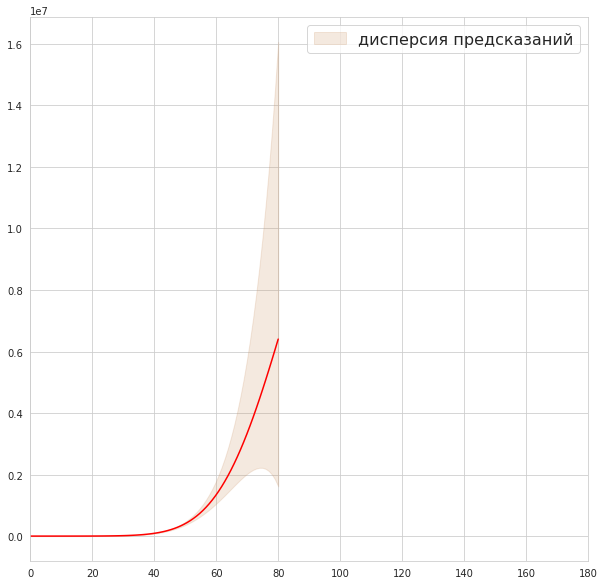

In [149]:
x = sample_statistics(mu_n, sigma_n, xs, n=100)
plot_predictions(xs, mu_n, x)

In [150]:
x_all_period = pd.concat([x_train, x_test]) 
N = len(x_all_period)
xs = np.linspace(0, len(x_all_period), N)
x = sample_statistics(mu_n, sigma_n, xs, n=100)

In [151]:
def calculation_interval(x ,number_col, a):
    x = x[:, number_col]
    n = len(x)
    mean = np.mean(x)
    d = np.var(x, ddof=1) * n / (n - 1)
    step = sp.t.ppf((a + 1) / 2, n - 1) * np.sqrt(d/n)

    return mean + step

In [152]:
date_start = pd.to_datetime("2020-03-03")
date_may = pd.to_datetime("2020-05-01")
date_june = pd.to_datetime("2020-06-01")
date_sept = pd.to_datetime("2020-09-01")

X_may = (date_may - date_start).days
X_june = (date_june - date_start).days
X_sept = (date_sept - date_start).days

print(f"К 1 мая: пессимистичном : {calculation_interval(x, X_may, 0.9)} , оптимистичном: {calculation_interval(x, X_may, 0.1)} случаев")
print(f"К 1 июня: пессимистичном : {calculation_interval(x, X_june, 0.9)} , оптимистичном: {calculation_interval(x, X_june, 0.1)} случаев")
print(f"К 1 сентября: пессимистичном : {calculation_interval(x, X_sept, 0.9)} , оптимистичном: {calculation_interval(x, X_sept, 0.1)} случаев")


К 1 мая: пессимистичном : 1391698.9389000467 , оптимистичном: 1337962.2561040751 случаев
К 1 июня: пессимистичном : 21494504.65790425 , оптимистичном: 18418550.44095303 случаев
К 1 сентября: пессимистичном : 234538074.26812476 , оптимистичном: 155916323.99620295 случаев


## Задание 4
 Проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

Выберем несколько стран из каждого континента:

In [153]:
countries = ["Japan", "China", "Singapore", 
              "Zimbabwe" ,
             "France", "Italy", "Greece", "Germany",
             "Australia", "Canada", "United States", "Cuba",
             "Brazil", "Argentina", "Mexico", "Peru"]

In [154]:
def creat_train_data_in_context_country(df, country):
    train_size = 50
    df_copy = df.copy()
    df_copy = df_copy[df_copy['location'] == country]

    df_copy['date'] = df_copy['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d") )
    train_data = df_copy[df_copy['total_cases'] > 2][:train_size]

    train_data['date'] = train_data['date'].apply(lambda x: (x - min(df_copy['date'])).days)
    train_data['free_value'] = np.ones(len(train_data))

    return train_data[['total_cases', 'date', 'free_value']]

In [155]:
res = {}
for contry in countries:
    train_data= creat_train_data_in_context_country(data, contry)
    x_train, y_train = train_data[['free_value','date']], train_data['total_cases']
    x_train['date^2'] = x_train['date'] ** 2 
    model_exp_reg = linear_model.LinearRegression(fit_intercept=False)
    model_exp_reg.fit(x_train, np.log(y_train))
    model_exp_reg.coef_
    res[contry] = [model_exp_reg.coef_[1], model_exp_reg.coef_[2]]

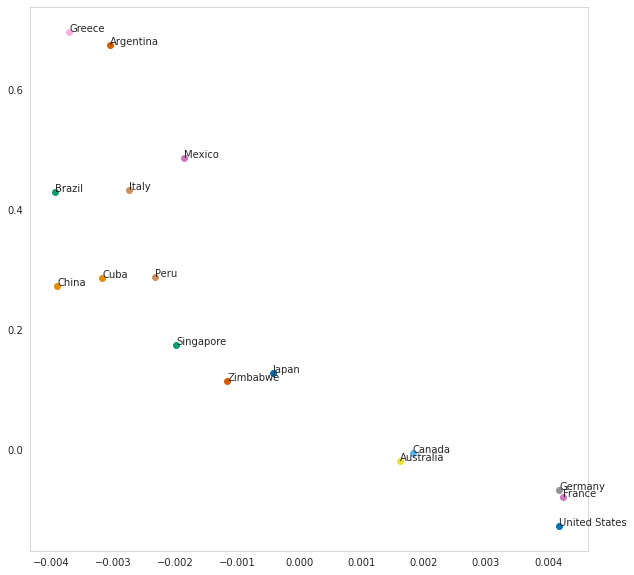

In [156]:
fig, ax = plt.subplots(figsize=(10, 10))
for contry in res.keys():
    w = res[contry]
    w_1, w_2 = w[1], w[0]
    ax.scatter(w_1, w_2)
    ax.annotate(contry, (w_1, w_2))
ax.grid()

Визуально можно выделитить 6 кластеров:
1. Австралия, Канада
2. Франция, Германия, США
3. Сингапур, Япония, Зимбабве 
4. Китай, Куба, Перу
5. Бразилия, Италия, Мексика
6. Греция, Аргетина
